In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from types import SimpleNamespace as Namespace
from ml.models.seq2seq_lstm import Seq2SeqLSTM
from ml.utils.data_utils import prepare_dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# ─────────────────────────────────────────────────────────────
# STEP 1: Define Config
args = Namespace(
    data_path='../dataset/combined_with_cluster_feature.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',
    use_time_features=False
)

In [3]:
# ─────────────────────────────────────────────────────────────
# STEP 2: Load Data with Cluster Feature
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

In [4]:
# ─────────────────────────────────────────────────────────────
# STEP 3: Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)


In [5]:
# ─────────────────────────────────────────────────────────────
# STEP 4: Model Init & Training
input_dim = X_train.shape[-1]
output_dim = y_train.shape[-1]
forecast_steps = args.forecast_steps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Seq2SeqLSTM(
    input_size=input_dim,
    hidden_size=64,
    output_size=output_dim,
    forecast_steps=forecast_steps
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.HuberLoss()  # More robust than MSE

# Training
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss:.4f}")

Epoch 1/50 - Train Loss: 3.5678
Epoch 2/50 - Train Loss: 2.5427
Epoch 3/50 - Train Loss: 2.3201
Epoch 4/50 - Train Loss: 2.1344
Epoch 5/50 - Train Loss: 2.0353
Epoch 6/50 - Train Loss: 1.9483
Epoch 7/50 - Train Loss: 1.8976
Epoch 8/50 - Train Loss: 1.8529
Epoch 9/50 - Train Loss: 1.8192
Epoch 10/50 - Train Loss: 1.8044
Epoch 11/50 - Train Loss: 1.7856
Epoch 12/50 - Train Loss: 1.7597
Epoch 13/50 - Train Loss: 1.7646
Epoch 14/50 - Train Loss: 1.7585
Epoch 15/50 - Train Loss: 1.7372
Epoch 16/50 - Train Loss: 1.7124
Epoch 17/50 - Train Loss: 1.7211
Epoch 18/50 - Train Loss: 1.7123
Epoch 19/50 - Train Loss: 1.6949
Epoch 20/50 - Train Loss: 1.6949
Epoch 21/50 - Train Loss: 1.6978
Epoch 22/50 - Train Loss: 1.6751
Epoch 23/50 - Train Loss: 1.6740
Epoch 24/50 - Train Loss: 1.6636
Epoch 25/50 - Train Loss: 1.6684
Epoch 26/50 - Train Loss: 1.6431
Epoch 27/50 - Train Loss: 1.6568
Epoch 28/50 - Train Loss: 1.6329
Epoch 29/50 - Train Loss: 1.6424
Epoch 30/50 - Train Loss: 1.6322
Epoch 31/50 - Train

In [6]:
# Save model
torch.save(model.state_dict(), "seq2seq_cluster_huber.pt")

## Evaluation

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace as Namespace
from sklearn.metrics import mean_squared_error, mean_absolute_error

from ml.utils.data_utils import prepare_dataset
from ml.models.seq2seq_lstm import Seq2SeqLSTM

In [8]:
# ─────────────────────────────────────────────────────────────
# STEP 1: Setup arguments
args = Namespace(
    data_path='../dataset/combined_with_cluster_feature.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',
    use_time_features=False
)

In [9]:
# ─────────────────────────────────────────────────────────────
# STEP 2: Load test data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

In [10]:
# ─────────────────────────────────────────────────────────────
# STEP 3: Load model
model = Seq2SeqLSTM(input_size=X_test.shape[2],
                    hidden_size=64,
                    output_size=y_test.shape[2],
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

model.load_state_dict(torch.load("seq2seq_cluster_huber.pt", map_location=device))
model.eval()

Seq2SeqLSTM(
  (encoder): LSTM(7, 64, batch_first=True)
  (decoder): LSTM(5, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

In [11]:
# ─────────────────────────────────────────────────────────────
# STEP 4: Inference
with torch.no_grad():
    preds = model(X_test_t, teacher_forcing_ratio=0)  # shape: [N, 6, 5]

preds = preds.cpu().numpy()
y_test = y_test  # still numpy

In [ ]:
# ─────────────────────────────────────────────────────────────
# STEP 5: Evaluation Metrics
def evaluate(pred, actual, name):
    mse = mean_squared_error(actual, pred)
    rmse = mean_squared_error(actual, pred, squared=False)
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    nrmse = rmse / (actual.max() - actual.min())

    print(f"\n {name} Evaluation:")
    print(f"  - MSE   : {mse:.4f}")
    print(f"  - RMSE  : {rmse:.4f}")
    print(f"  - MAE   : {mae:.4f}")
    print(f"  - R²    : {r2:.4f}")
    print(f"  - NRMSE : {nrmse:.4f}")

# Loop through all target variables
print("\nEvaluation Metrics for All 5 Targets:")
for var in args.targets:
    idx = args.targets.index(var)
    pred_values = preds[:, :, idx].flatten()
    true_values = y_test[:, :, idx].flatten()
    evaluate(pred_values, true_values, var)


Evaluation Metrics for All 5 Targets:

 rnti_count Evaluation:
  - MSE   : 0.0077
  - RMSE  : 0.0875
  - MAE   : 0.0658
  - R²    : 0.5105
  - NRMSE : 0.1223

 rb_down Evaluation:
  - MSE   : 0.0106
  - RMSE  : 0.1032
  - MAE   : 0.0510
  - R²    : 0.4364
  - NRMSE : 0.1033

 rb_up Evaluation:
  - MSE   : 0.0166
  - RMSE  : 0.1289
  - MAE   : 0.0601
  - R²    : 0.4666
  - NRMSE : 0.1289

 down Evaluation:
  - MSE   : 0.0086
  - RMSE  : 0.0925
  - MAE   : 0.0541
  - R²    : 0.3942
  - NRMSE : 0.0929

 up Evaluation:
  - MSE   : 0.0142
  - RMSE  : 0.1192
  - MAE   : 0.0551
  - R²    : 0.4103
  - NRMSE : 0.1192


## Visualization

In [13]:
# ─────────────────────────────────────────────────────────────
# STEP 6: Visualizations

def plot_all_steps(preds, y_test, var_name):
    idx = args.targets.index(var_name)
    fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
    for t in range(6):
        axs[t].plot(preds[:, t, idx], label='Predicted', linestyle='--')
        axs[t].plot(y_test[:, t, idx], label='Actual', alpha=0.7)
        axs[t].set_title(f"{var_name} — t+{t+1}")
        axs[t].legend()
    plt.tight_layout()
    plt.show()

def plot_sample_steps(preds, y_test, sample_idx, var_name):
    idx = args.targets.index(var_name)
    plt.plot(range(1, 7), y_test[sample_idx, :, idx], label="Actual", marker='o')
    plt.plot(range(1, 7), preds[sample_idx, :, idx], label="Predicted", marker='x')
    plt.title(f"{var_name} — Forecast for sample {sample_idx}")
    plt.xlabel("t+")
    plt.ylabel("Scaled value")
    plt.xticks(range(1, 7))
    plt.grid(True)
    plt.legend()
    plt.show()


 Forecast plots for rb_down


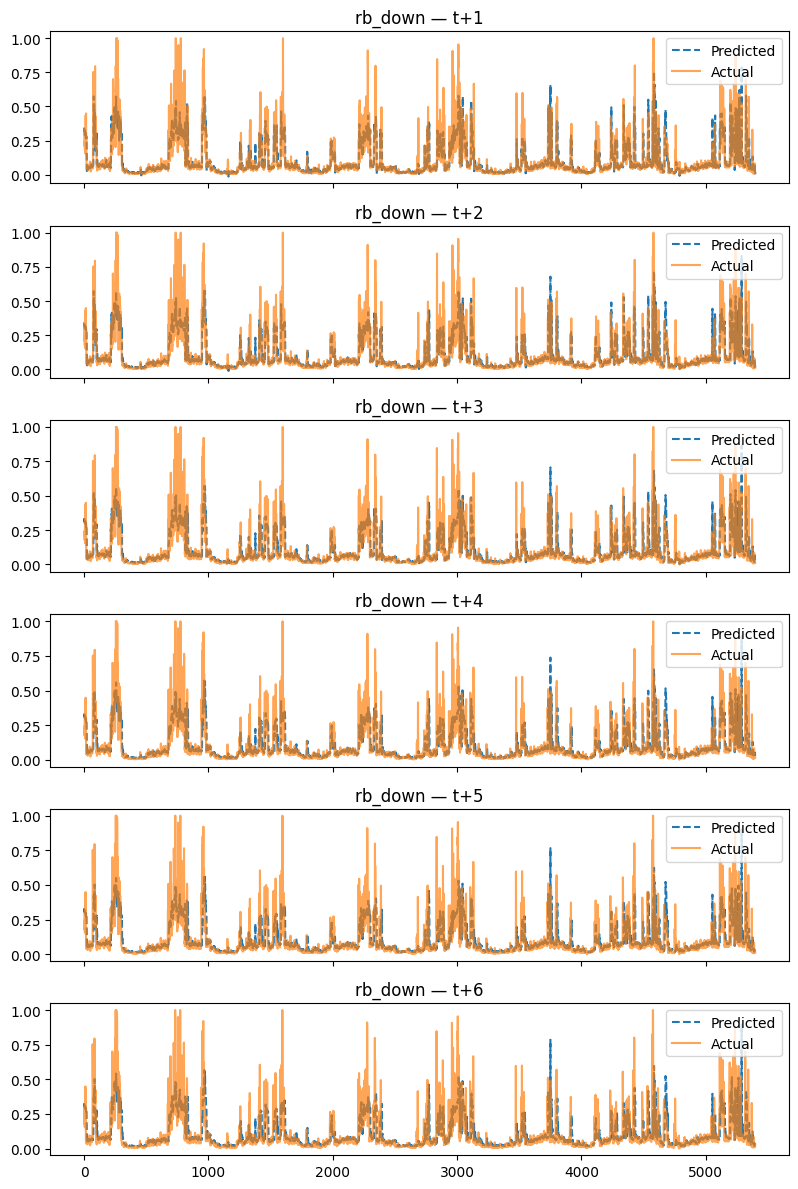

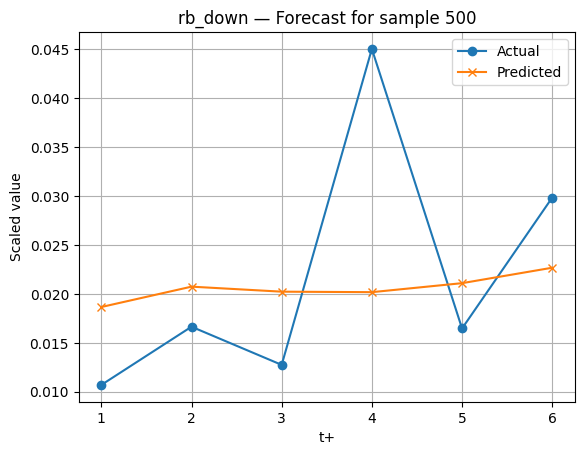


 Forecast plots for down


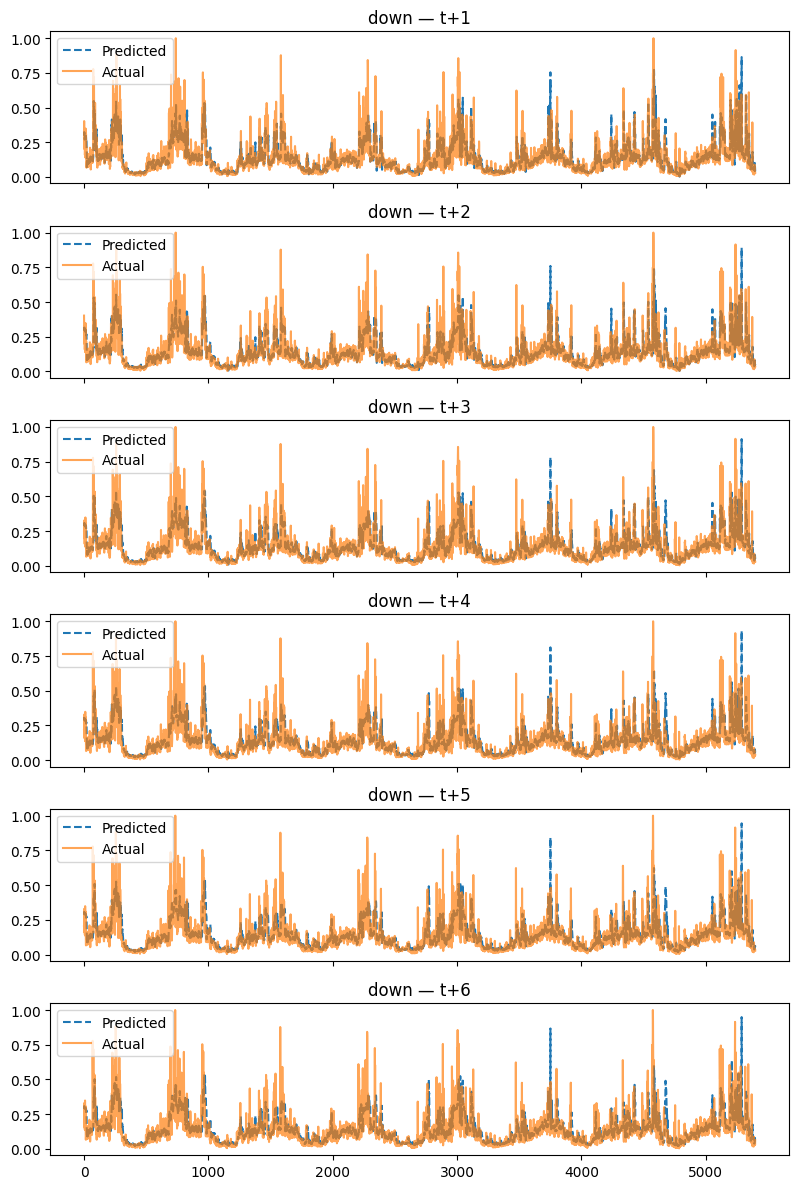

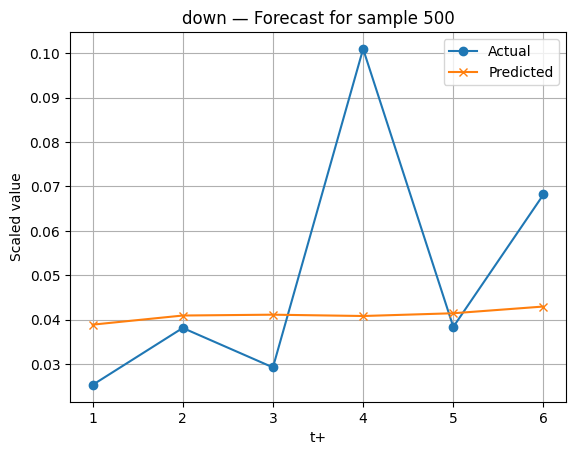

In [15]:
# ───────────── Plot both variables ─────────────
for var in ['rb_down', 'down']:
    print(f"\n Forecast plots for {var}")
    plot_all_steps(preds, y_test, var)
    plot_sample_steps(preds, y_test, sample_idx=500, var_name=var)